# Recomendación de Anime basado en grupos (clusters) de usuarios

![imglink](http://img02.deviantart.net/42b7/i/2015/092/1/2/ultimate_anime_world_cup_by_cristyann-d8o38t3.jpg)

(Image taken from [imglink](http://img02.deviantart.net/42b7/i/2015/092/1/2/ultimate_anime_world_cup_by_cristyann-d8o38t3.jpg))

# Introducción

Basado en https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation .

Usando la base de datos de anime, creamos un sistema de recomendación que usa la técnica de agrupamiento (clustering).<br>
El anime que se recomienda se extrae de las características del **cluster (grupo)**.<br>
El usuario está segmentado (ordenado) por el historial de los animes que le han gustado, seleccionando solo los anime que al usuario realmente le **gustan**.<br>


En este kernel / notebook / libro hacemos: 

 - Limpiar y preparar los datos (Data wrangling)
 - Agrupación / clustering por [K mean](https://es.wikipedia.org/wiki/K-medias).
 - Caracterización de cada cluster.


Importamos librerias (herramientas) que necesitamos para este ejercicio.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

Descargamos (curl) y descomprimimos (unzip) de Github los datasets que vamos a usar. Guardamos el conjunto de datos (**dataset**) de animes en la variable 'anime'.

In [2]:
!curl 'https://raw.githubusercontent.com/apolmig/AppliedAI_basic/master/Recommendation/Anime/anime_recommendation_datasets.zip' --output anime_recommendation_datasets.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.3M  100 20.3M    0     0  19.2M      0  0:00:01  0:00:01 --:--:-- 19.2M


In [3]:
!unzip anime_recommendation_datasets.zip


Archive:  anime_recommendation_datasets.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [4]:
anime = pd.read_csv('anime.csv') 

Montar nuestro Drive en este Notebook. EJECUTAR SOLO SI QUEREMOS ACCEDER A NUESTRO DRIVE.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

Vemos las cabecera (_head_), titulos de las columnas del _dataset_ de Anime, así como una pequeña muestra, como se puede ver, tenemos el identificador del anime, el titulo, genero, formato, episodios que tiene, puntuación (_rating_) y el número de usuarios que lo han puntuado.

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Vemos cuantas filas y columnas tiene el _Dataset_ con la funcion _shape_

In [6]:
print(anime.shape)

(12294, 7)


Cargamos el _Dataset_ de lo que a cada usuario le ha gustado en la variable _user_

In [7]:
user = pd.read_csv('rating.csv')

En esta ocasión, echamos un vistazo al _dataset_ de usuarios viendo la cabecera (_head_) y una muestra, vemos que cada usuario (*user_id*) ha puntuado (_rating_) diferentes animes (*anime_id*)

In [8]:
user.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


Y vemos el numero de filas y columnas (funcion _shape_)

In [9]:
print(user.shape)

(7813737, 3)


## Definición de "Like"

    Dado que hay tantas opiniones de animes como usuarios (casi 8 millones!!), para reducir la complejidad, calculamos la media (promedio) de valoraciones de cada usuario.
    Y por definición, decidimos que si un anime tiene una media de valoraciones superior a la media de valoraciones del usuario, le asignamos un "like".

![imglink](http://matemnews.com/wp-content/uploads/2018/06/2011-08-31_072046_Facebook-Like-Button-big-500x242.jpg)


In [10]:
# Por ejemplo, el usuario 1 tiene de media de valoraciones en negativo... no le gusta nada de nada!!

user[user['user_id']==1].rating.mean()

-0.7124183006535948

In [11]:
# El usuario 2 tiene una media de valoraciones muy baja...

user[user['user_id']==2].rating.mean()

2.6666666666666665

In [12]:
# hmm, el usuario 5 tiene una media de valoracion de casi 5, que es la mitad del máximo posible (10)..
# bueno, que publico más exigente!
user[user['user_id']==5].rating.mean()

4.263383297644539

In [13]:
# bueno bueno, el usuario 1589 tiene una media de valoracion de casi 8, vemos que hay usuarios más positivos con lo que ven.
user[user['user_id']==1589].rating.mean()

7.855555555555555

### Calculamos la media de valoraciones para cada usuario

A la variable **MRPU** le asignamos todo el _dataset_ de usuarios pero calculando la media y guardando solo ese dato.

In [14]:
MRPU = user.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']


MRPU.drop(['anime_id','rating'],axis=1, inplace=True)

In [15]:
# vemos lo que hay en la cabecera del MRPU

MRPU.head(10)

,user_id,mean_rating
0,1,-0.712418
1,2,2.666667
2,3,7.382979
3,4,-1.000000
4,5,4.263383
5,6,-1.000000
6,7,7.387755
7,8,8.333333
8,9,8.000000
9,10,2.875000


### Fusionamos el _dataset_ de _User_ con el de medias (_MRPU_), creando un _dataset_ nuevo

In [16]:
user = pd.merge(user,MRPU,on=['user_id','user_id'])

In [17]:
# Echamos un vistazo al _dataset_ _User_ despues de la fusión

user.head(10)

,user_id,anime_id,rating,mean_rating
0,1,20,-1,-0.712418
1,1,24,-1,-0.712418
2,1,79,-1,-0.712418
3,1,226,-1,-0.712418
4,1,241,-1,-0.712418
5,1,355,-1,-0.712418
6,1,356,-1,-0.712418
7,1,442,-1,-0.712418
8,1,487,-1,-0.712418
9,1,846,-1,-0.712418


In [18]:
# eliminamos del _dataset_ los animes que tienen una valoracion inferior a la media

user = user.drop(user[user.rating < user.mean_rating].index)

In [19]:
# por ejemplo, ahora vemos que el usuario 1 tiene 3 animes favoritos (media de valoracion > a su media)

user[user['user_id']== 1].head(10)

,user_id,anime_id,rating,mean_rating
47,1,8074,10,-0.712418
81,1,11617,10,-0.712418
83,1,11757,10,-0.712418
101,1,15451,10,-0.712418


In [20]:
# user2 favorite only one anime

user[user['user_id']== 2].head(10)

,user_id,anime_id,rating,mean_rating
153,2,11771,10,2.666667


In [21]:
user[user['user_id']== 5].head(10)

,user_id,anime_id,rating,mean_rating
302,5,6,8,4.263383
303,5,15,6,4.263383
304,5,17,6,4.263383
305,5,18,6,4.263383
306,5,20,6,4.263383
307,5,22,5,4.263383
310,5,45,7,4.263383
311,5,47,8,4.263383
312,5,57,7,4.263383
314,5,67,6,4.263383


In [22]:
user[user['user_id']== 1589].head(10)

,user_id,anime_id,rating,mean_rating
159673,1589,64,8,7.855556
159674,1589,65,8,7.855556
159675,1589,66,10,7.855556
159676,1589,71,9,7.855556
159677,1589,72,9,7.855556
159678,1589,73,9,7.855556
159679,1589,76,8,7.855556
159680,1589,77,9,7.855556
159681,1589,133,8,7.855556
159682,1589,134,9,7.855556


In [23]:
# vemos que tamaño tiene nuestro _dataset_ ... uff.. todavía más de 8 millones de filas!

print(user.shape)

(4262566, 4)


In [24]:
user["user_id"].unique()

array([    1,     2,     3, ..., 73514, 73515, 73516])

In [25]:
user = user.rename({'rating':'userRating'}, axis='columns')

## Combine two datasets

       In this kernel, I decide to reduce size of dataset, because of running time

In [26]:
# merge 2 dataset
mergedata = pd.merge(anime,user,on=['anime_id','anime_id'])
mergedata= mergedata[mergedata.user_id <= 20000]
mergedata.head(10)

,anime_id,name,genre,type,episodes,rating,members,user_id,userRating,mean_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,7.699301
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,8.729242
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,7.372287
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10,8.356322
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10,-0.832298
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8,7.374593
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490,10,8.062500
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548,10,8.112360
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,570,10,8.388889
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,598,10,8.680328


In [27]:
len(mergedata['anime_id'].unique())

7852

In [28]:
len(anime['anime_id'].unique())

12294

## Create Crosstable 

    Show detail of anime which each user like

In [29]:
user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])
user_anime.head(10)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2005-nen Uchuu no Tabi,...,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Koihime,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zonmi-chan: Halloween☆Special Movie!,Zonmi-chan: Meat Pie of the Dead,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver the Movie Specials,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,fake!fake!,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
user_anime.shape

(20000, 7852)

## Principal Component Analysis

[Principal Component Analysis (PCA)](https://es.wikipedia.org/wiki/Analisis_de_componentes_principales)
    
 PCA es un tipo de análisis que convierte nuestras variables originales en otras nuevas, las cuales son una combinación lineal del conjunto original, o sea, una especie de simplificación.
 Con esto, el objetivo es reducir la dimension de los datos para poder hacer agrupaciones (_clustering_) y visualizar.

In [31]:
# nos traemos (import) la herramienta PCA

from sklearn.decomposition import PCA

# aplicamos PCA al dataset fusionado que hemos generado anteriormente usando pca.fit
# ademas, cogemos una muestra de transformación

pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

In [32]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,-1.579129,-0.500240,0.415763
1,-1.773553,-0.272593,0.116389
2,0.218814,-1.232282,-0.985809
3,0.199435,-0.291005,0.681054
4,3.532125,-0.184796,-0.743288


In [33]:
tocluster = pd.DataFrame(ps[[0,1,2]])

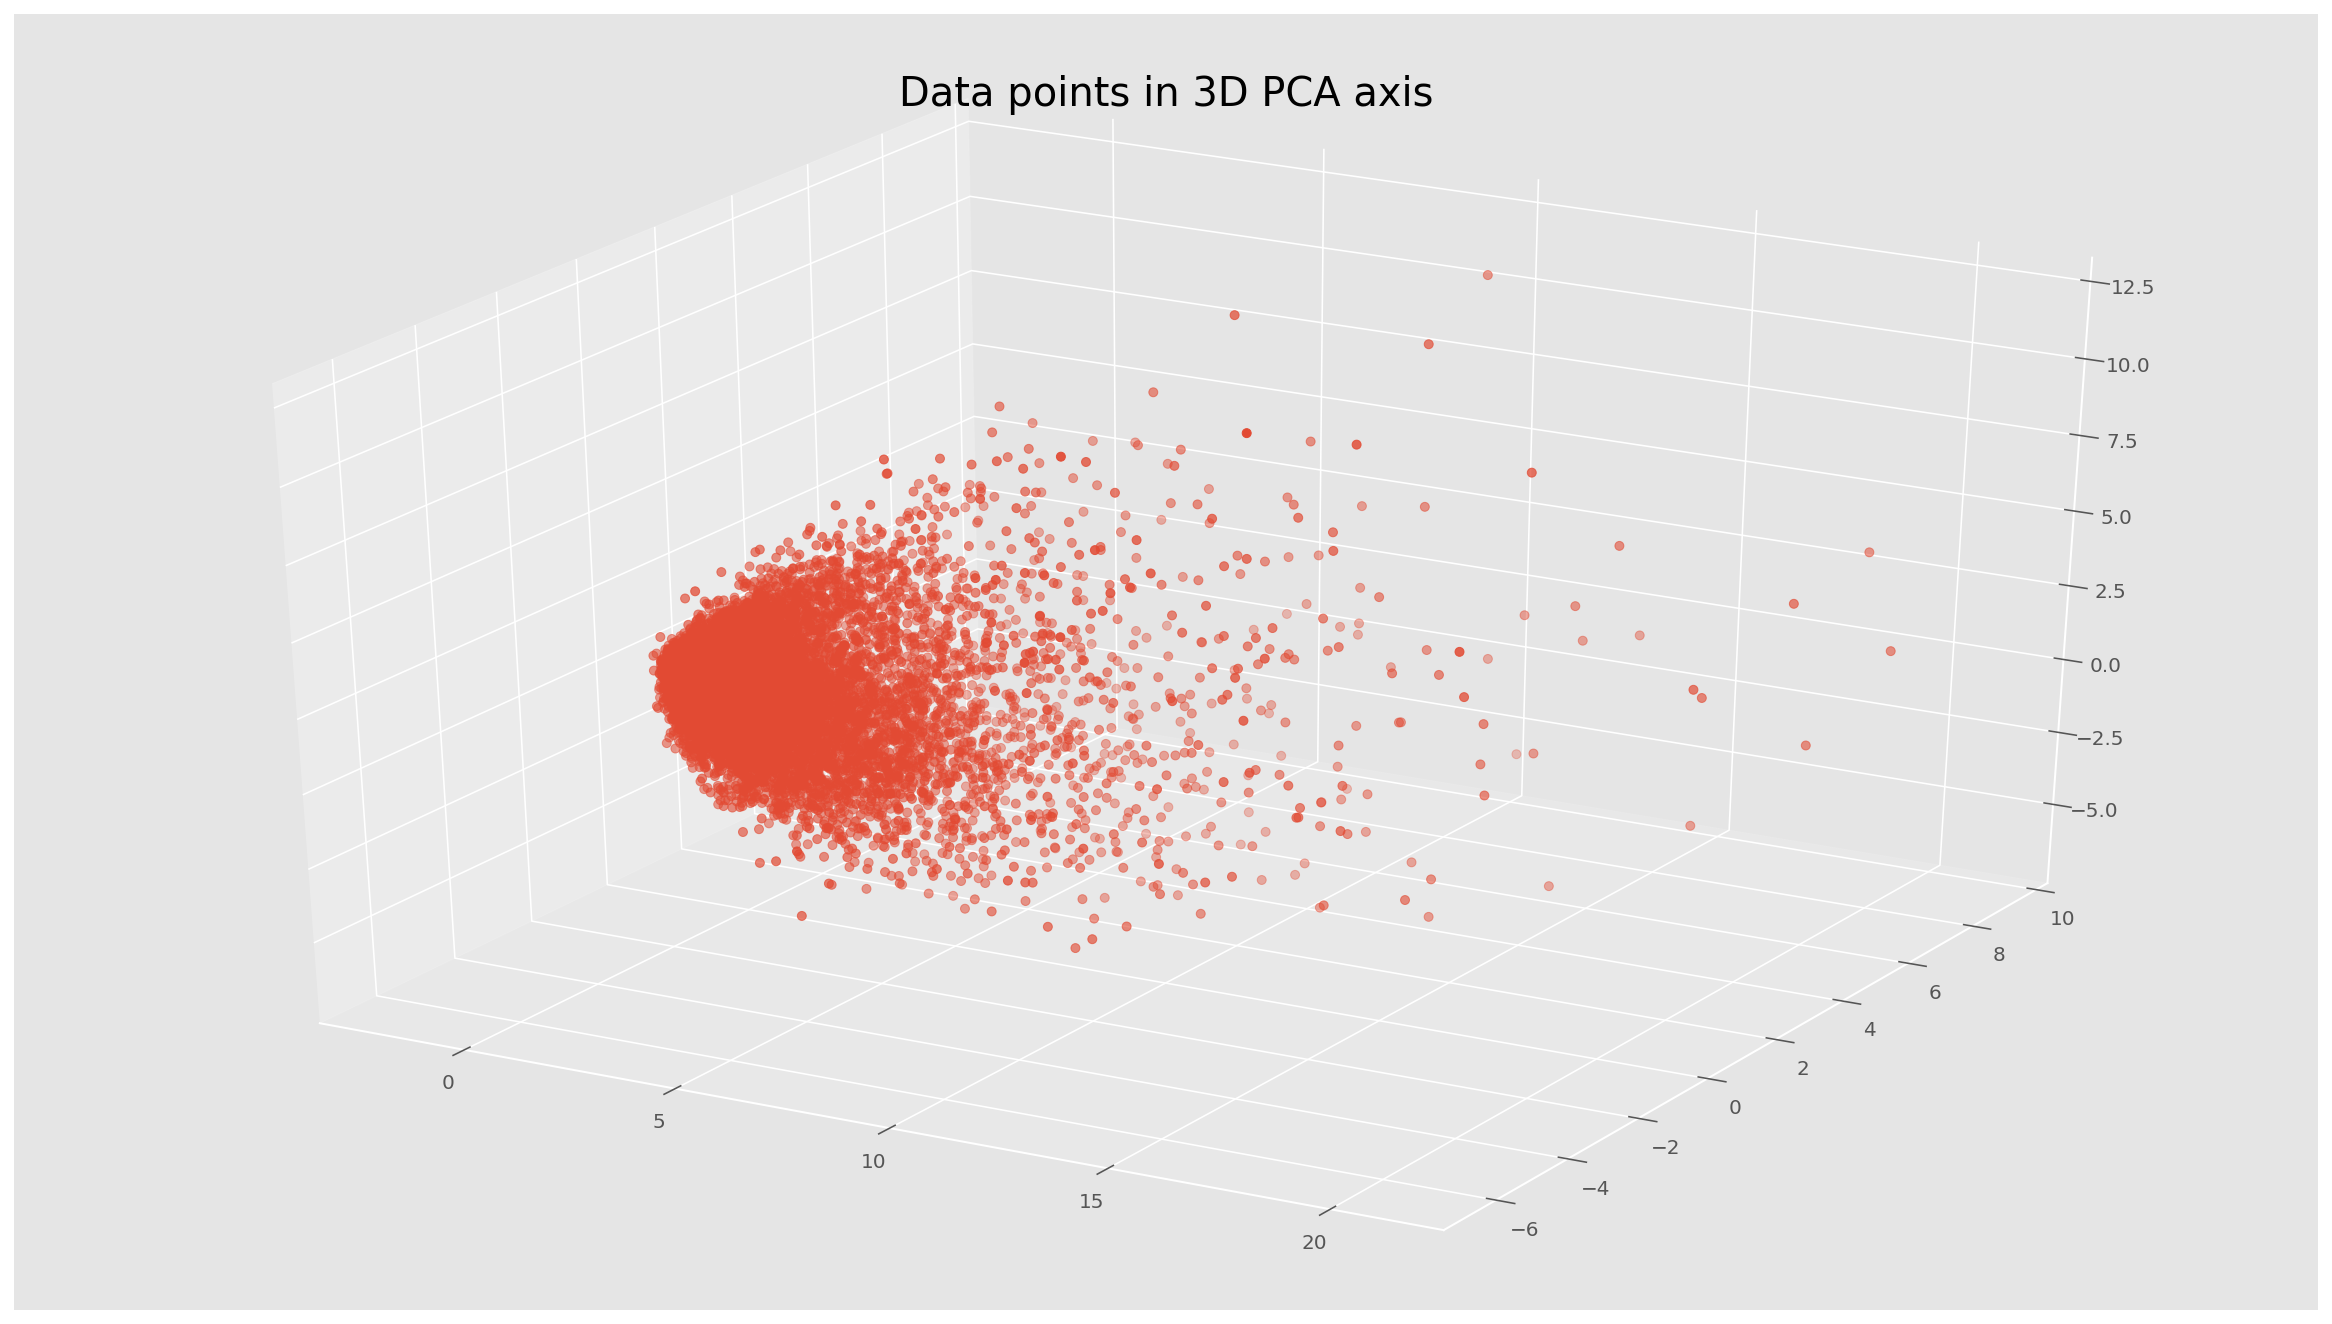

In [34]:
# hacemos una visualización 3D de los datos que hemos transformado

plt.rcParams['figure.figsize'] = (16, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()


## Selecting number of k

In [35]:
# Ahora vamos a hacer agrupaciones (clusters), para eso necesitamos la funcion KMeans que nos traemos

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))
    


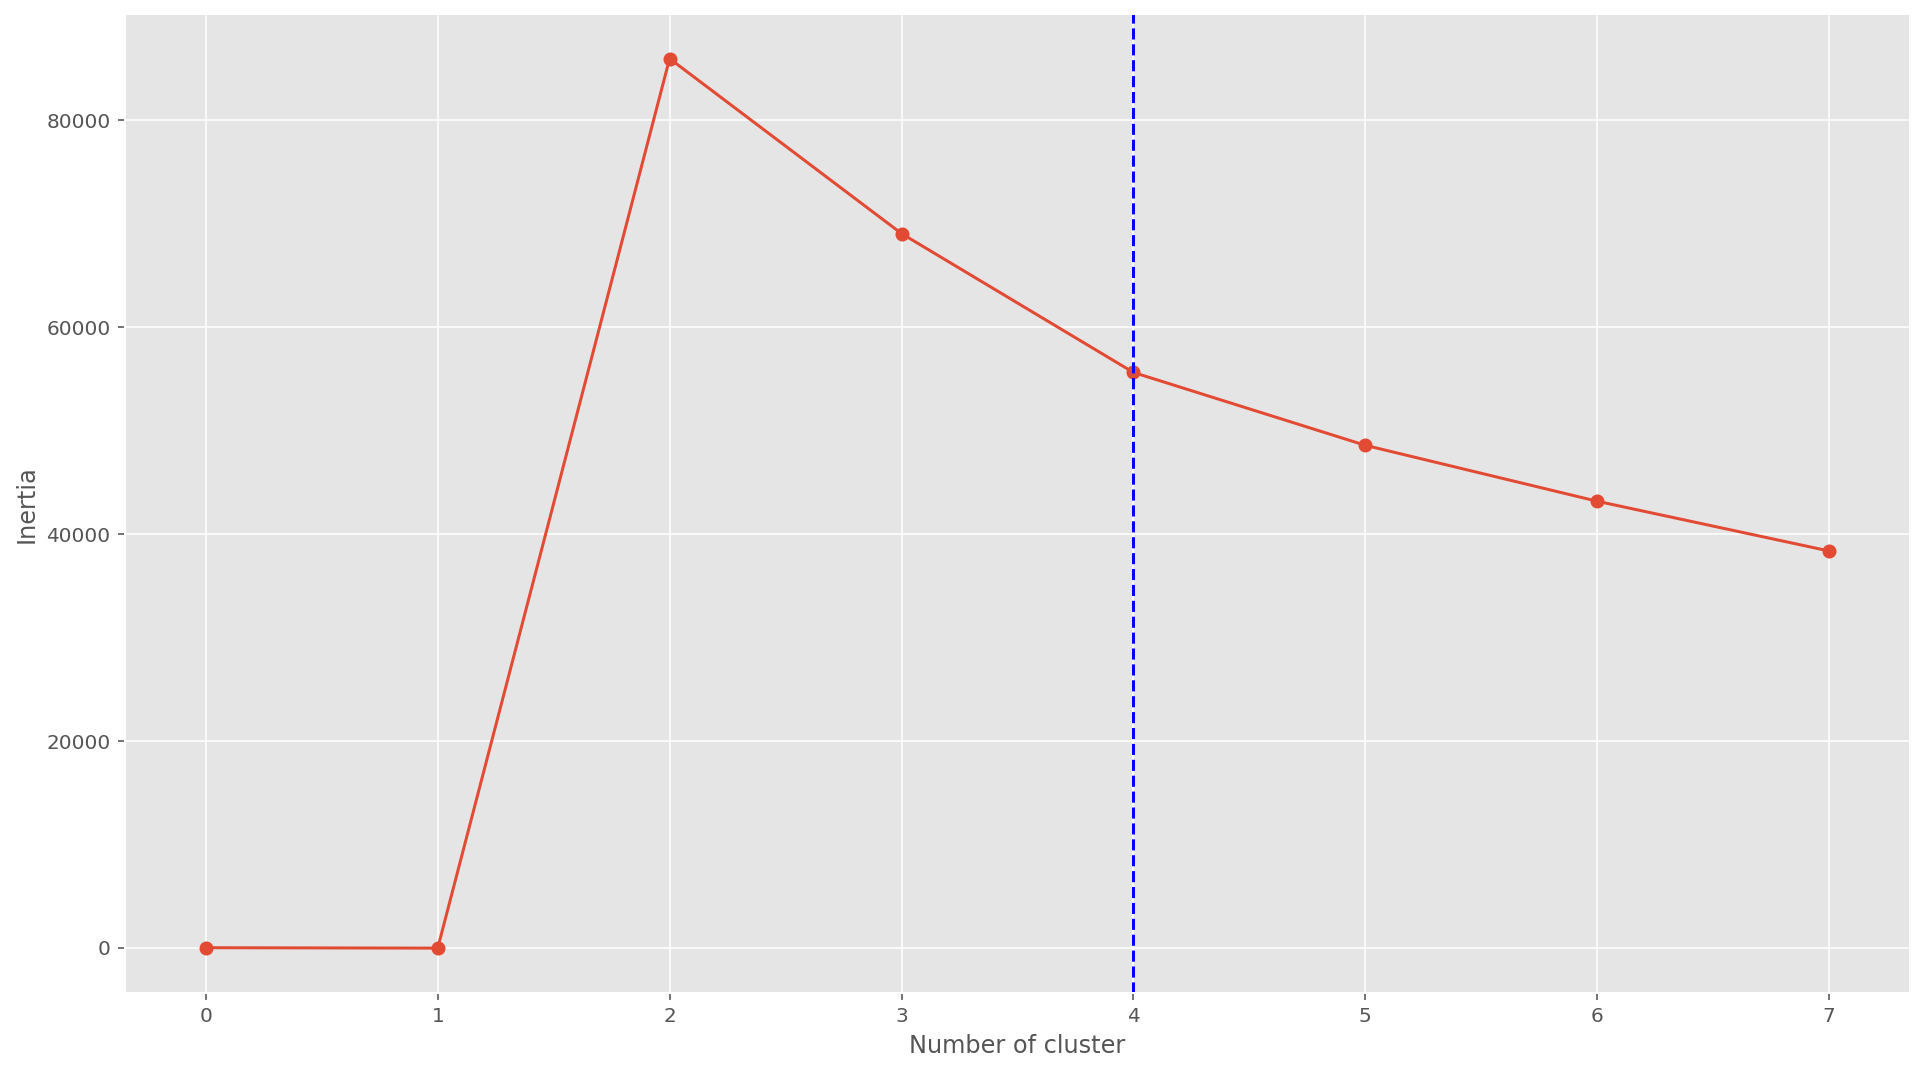

In [36]:
# lo dibujamos

plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

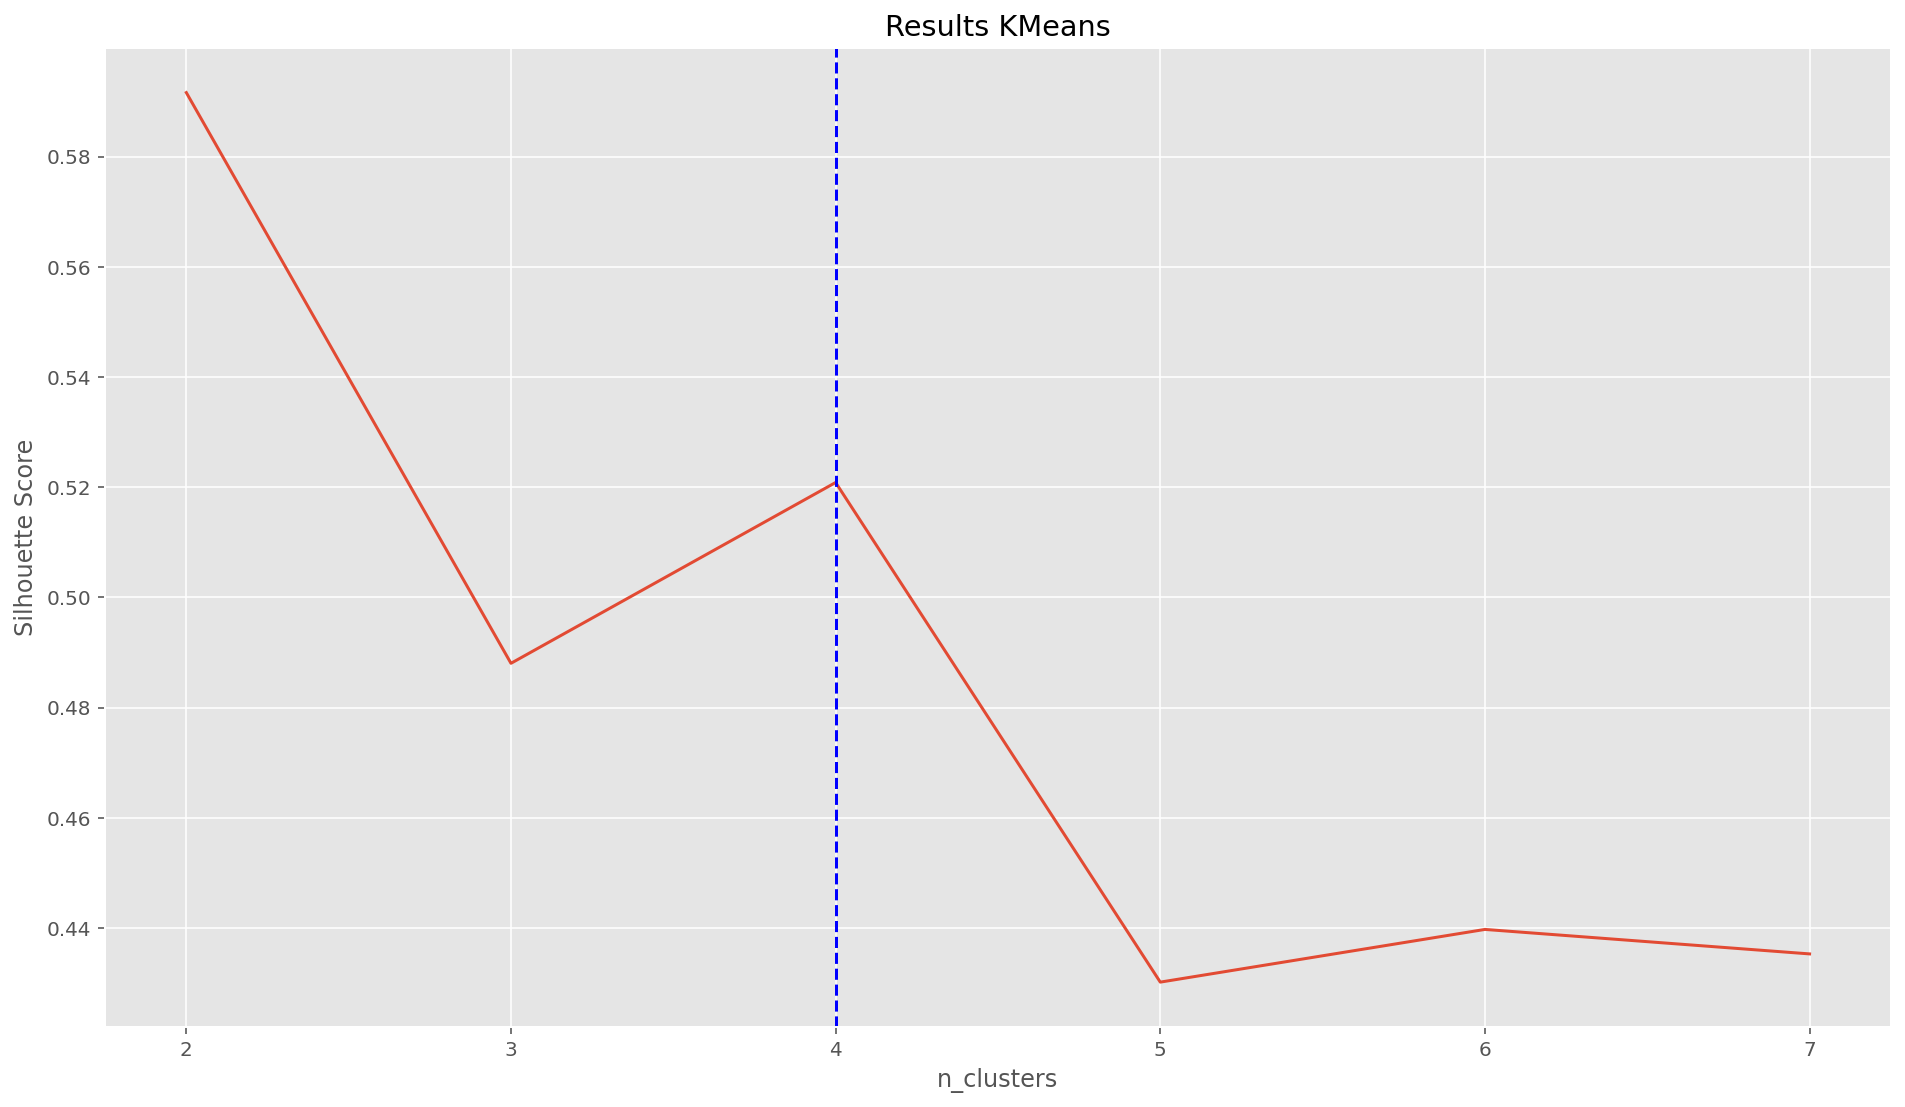

In [37]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

## K means clustering

In [38]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[ 1.90045273 -1.09606749 -0.44700106]
 [-1.09748002 -0.03718035  0.06961236]
 [ 7.42138078 -0.71317144  0.78751324]
 [ 1.67073597  2.32444766 -0.01593706]]


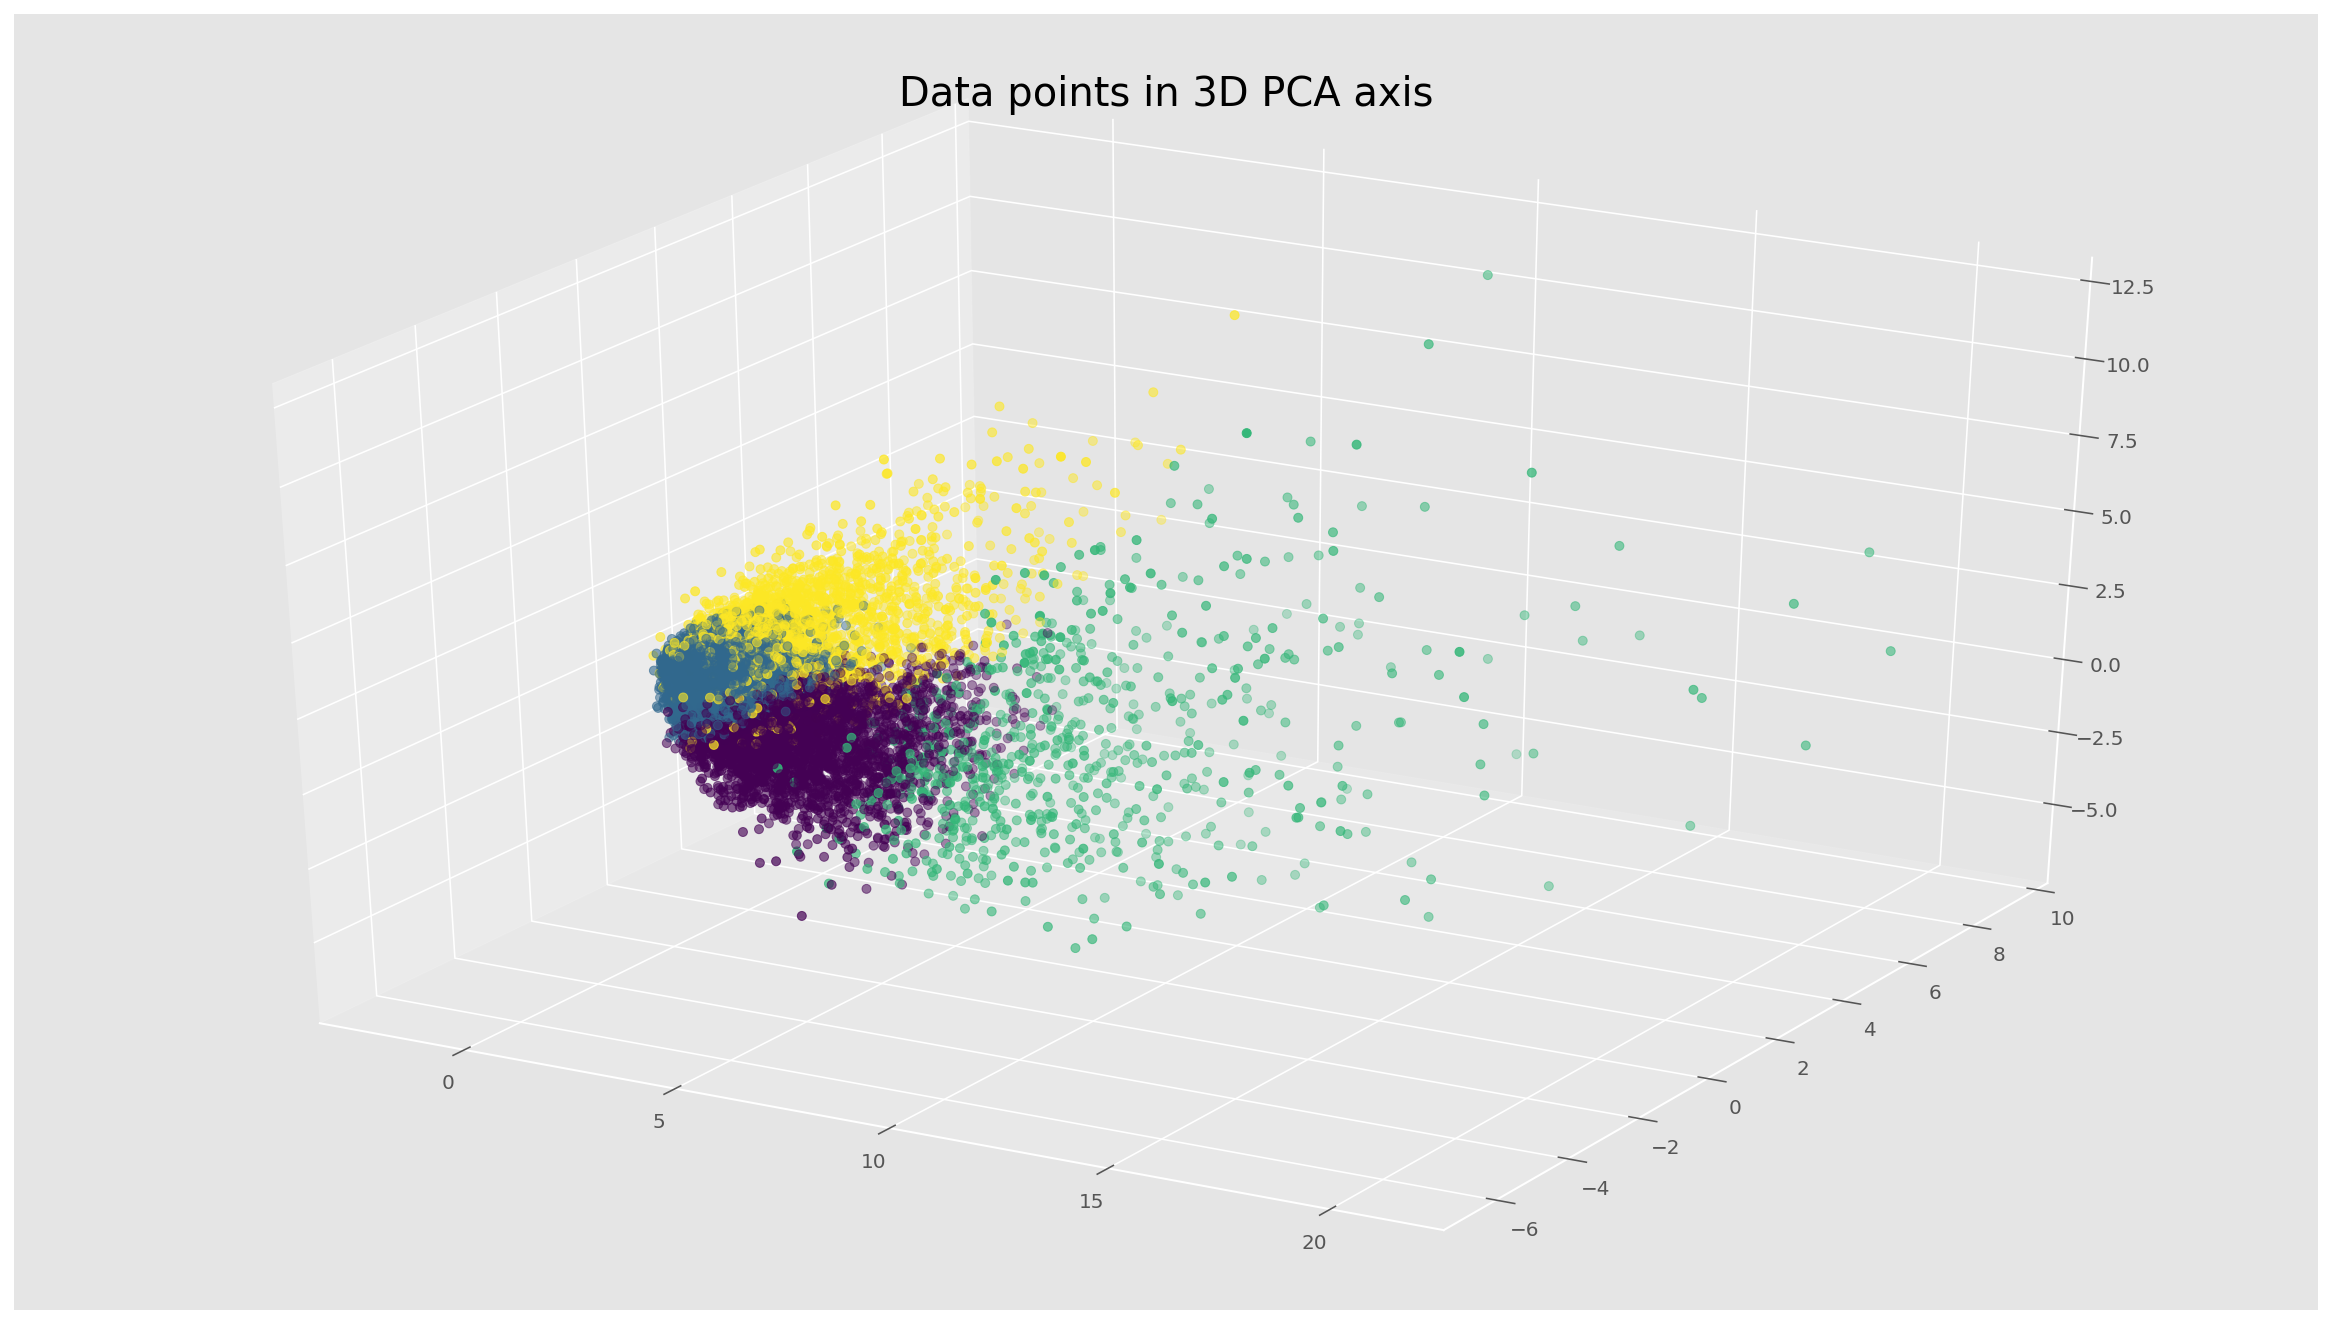

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

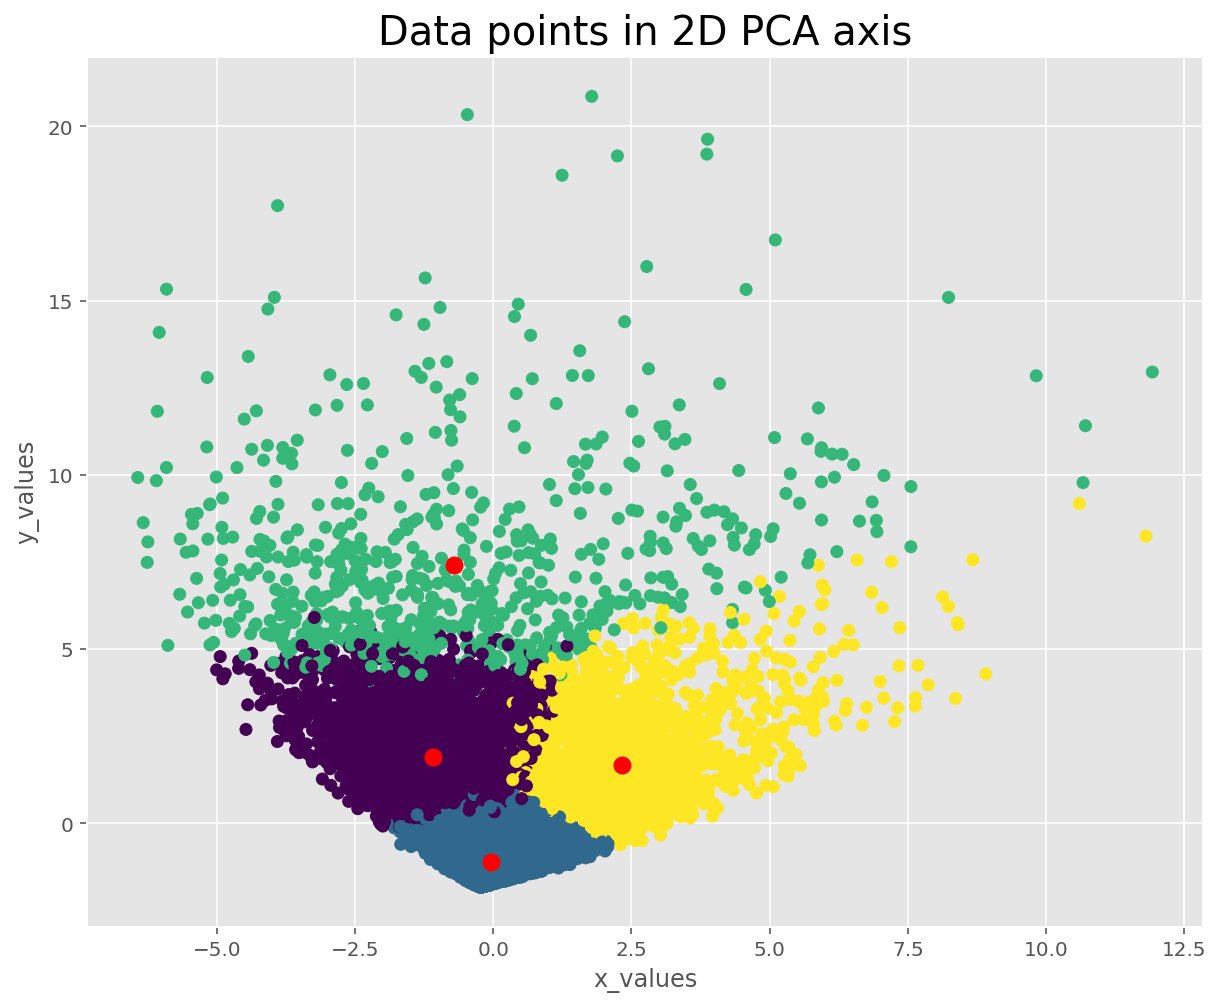

In [40]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

In [41]:
user_anime['cluster'] = c_preds


user_anime.head(10)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2005-nen Uchuu no Tabi,...,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Koihime,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zonmi-chan: Halloween☆Special Movie!,Zonmi-chan: Meat Pie of the Dead,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver the Movie Specials,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,fake!fake!,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
user_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Columns: 7853 entries, &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi to cluster
dtypes: int32(1), int64(7852)
memory usage: 1.2 GB


## Characteristic of each cluster

In [43]:

c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()


### Cluster 0

    Top 15 anime which will explain characteristic of this cluster

In [44]:
c0.sort_values(ascending=False)[0:15]

name
Shingeki no Kyojin                                          0.722766
No Game No Life                                             0.633719
Sword Art Online                                            0.607896
Death Note                                                  0.589789
Angel Beats!                                                0.589196
Steins;Gate                                                 0.545266
Fullmetal Alchemist: Brotherhood                            0.535767
Toradora!                                                   0.510240
Mirai Nikki (TV)                                            0.504898
Code Geass: Hangyaku no Lelouch                             0.501633
Code Geass: Hangyaku no Lelouch R2                          0.473731
One Punch Man                                               0.458890
Noragami                                                    0.457703
Tokyo Ghoul                                                 0.455031
Ano Hi Mita Hana no Namae wo 

In [45]:
def createAnimeInfoList(animelist):
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime['name']:
        if x in animelist:
            episode_list.append(anime[anime['name']==x].episodes.values.astype(int))
            member_list.append(anime[anime['name']==x].members.values.astype(int))
            rating_list.append(anime[anime['name']==x].rating.values.astype(int))
            for y in anime[anime['name']==x].genre.values:
                 genre_list.append(y)
    return genre_list,episode_list,rating_list,member_list
         

In [46]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(','):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [47]:
animelist = list(c0.index)
data = pd.DataFrame()
data['genre'],data['episode'],data['rating'],data['member'] =  createAnimeInfoList(animelist)


In [48]:

set_keywords = set()
for liste_keywords in data['genre'].str.split(',').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)


In [49]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

    Favorite genre for this cluster 

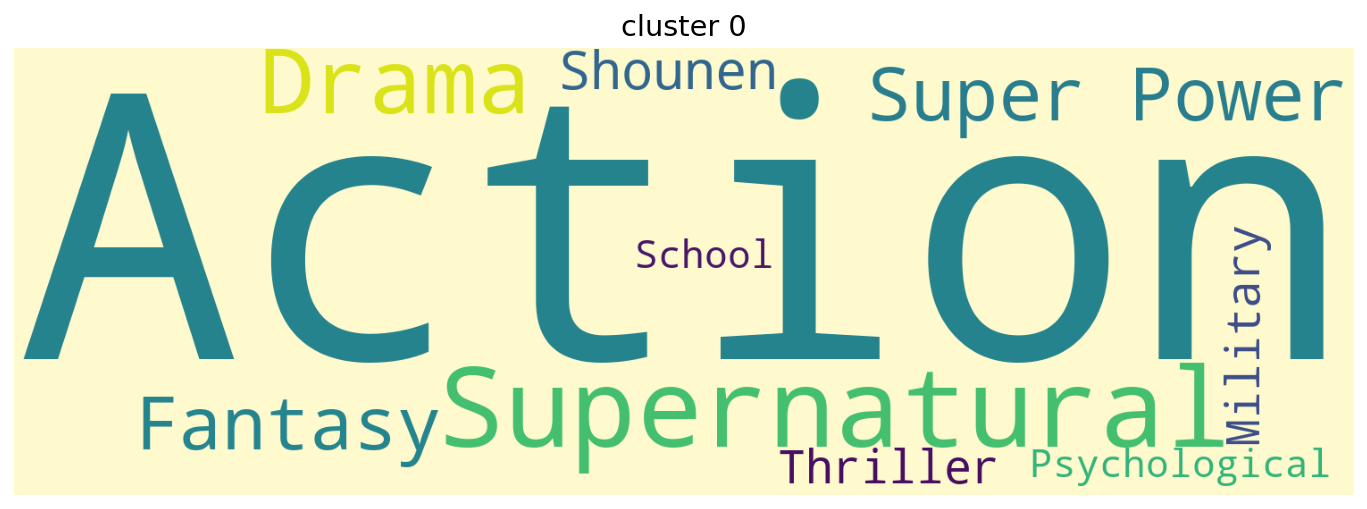

In [50]:
c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

In [51]:
keyword_occurences[0:5]

[['Action', 10],
 [' Supernatural', 8],
 [' Drama', 5],
 [' Super Power', 4],
 [' Fantasy', 4]]

    Average of each information for anime which user in this cluster like

In [52]:
print('cluster 0\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c0_data['episode'].mean(), c0_data['rating'].mean(),c0_data['member'].mean()))

cluster 0
AVG episode : 23.2
AVG movie rating : 8.066666666666666
AVG member : 687956.2


### Cluster 1

In [53]:
c1.sort_values(ascending=False)[0:15]

name
Death Note                            0.319365
Shingeki no Kyojin                    0.228056
Sword Art Online                      0.197115
Fullmetal Alchemist: Brotherhood      0.179877
Code Geass: Hangyaku no Lelouch       0.177786
Sen to Chihiro no Kamikakushi         0.159322
Angel Beats!                          0.155788
Fullmetal Alchemist                   0.155644
Code Geass: Hangyaku no Lelouch R2    0.152398
Naruto                                0.145330
Elfen Lied                            0.143671
Ouran Koukou Host Club                0.133646
Mirai Nikki (TV)                      0.119942
Toradora!                             0.116408
Howl no Ugoku Shiro                   0.114172
dtype: float64

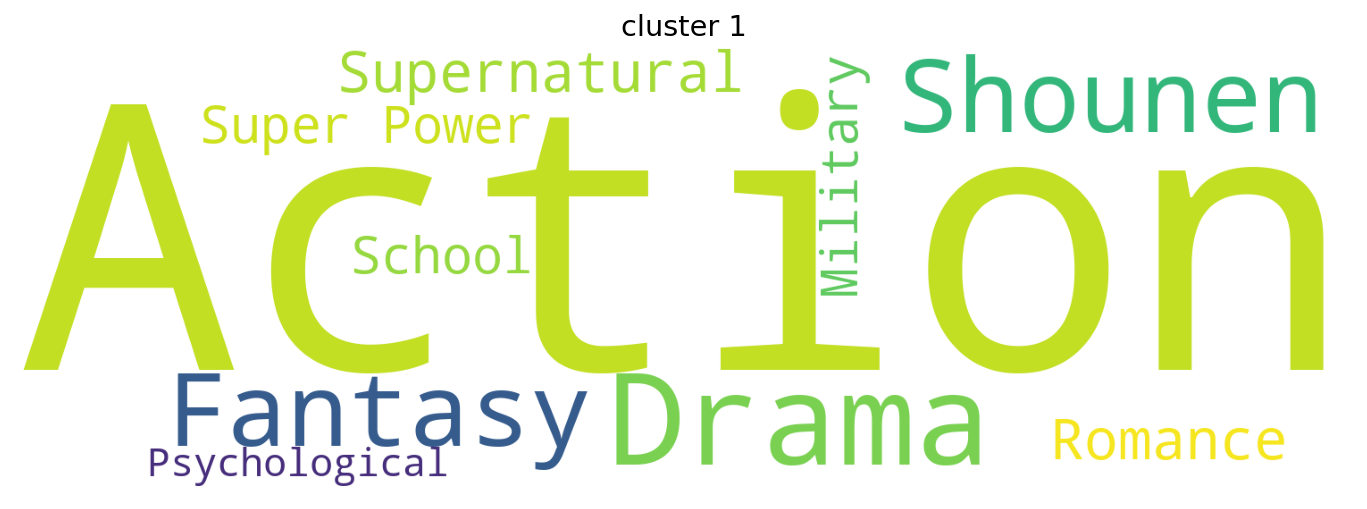

In [54]:
c1_animelist = list(c1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 1","white")

In [55]:
keyword_occurences[0:5]

[['Action', 10],
 [' Drama', 8],
 [' Fantasy', 5],
 [' Shounen', 5],
 [' Supernatural', 5]]

In [56]:
print('cluster 1\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c1_data['episode'].mean(), c1_data['rating'].mean(),c1_data['member'].mean()))

cluster 1
AVG episode : 38.46666666666667
AVG movie rating : 7.866666666666666
AVG member : 668177.0666666667


### Cluster 2

In [57]:
c2.sort_values(ascending=False)[0:15]

name
Angel Beats!                                           0.829670
No Game No Life                                        0.824176
Toradora!                                              0.809066
Steins;Gate                                            0.791209
Code Geass: Hangyaku no Lelouch                        0.789835
Shingeki no Kyojin                                     0.782967
Sword Art Online                                       0.766484
Code Geass: Hangyaku no Lelouch R2                     0.763736
Death Note                                             0.748626
Bakemonogatari                                         0.745879
Fullmetal Alchemist: Brotherhood                       0.732143
Hataraku Maou-sama!                                    0.726648
Mirai Nikki (TV)                                       0.723901
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.717033
Clannad                                                0.712912
dtype: float64

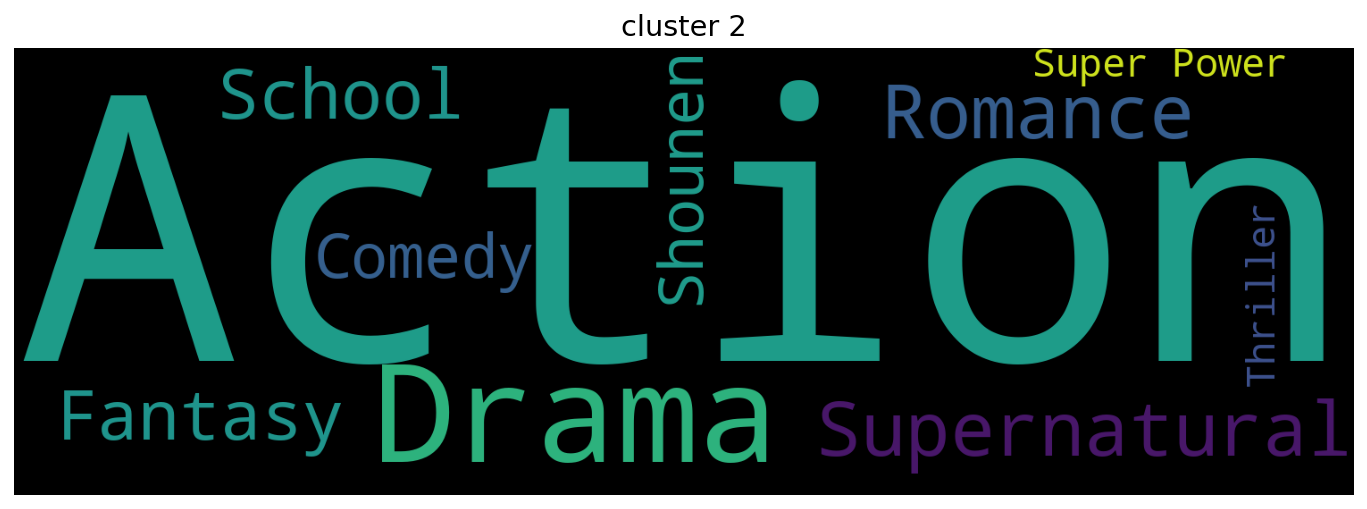

In [58]:
c2_animelist = list(c2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 2","black")

In [59]:
keyword_occurences[0:5]

[['Action', 7],
 [' Drama', 6],
 [' Supernatural', 6],
 [' Romance', 6],
 [' Fantasy', 5]]

In [60]:
c2_data['episode'].mean()

24.333333333333332

In [61]:
print('cluster 2\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c2_data['episode'].mean(), c2_data['rating'].mean(),c2_data['member'].mean()))

cluster 2
AVG episode : 24.333333333333332
AVG movie rating : 8.066666666666666
AVG member : 665432.4666666667


### Cluster 3

In [62]:
c3.sort_values(ascending=False)[0:15]

name
Death Note                            0.679588
Code Geass: Hangyaku no Lelouch       0.668793
Code Geass: Hangyaku no Lelouch R2    0.609912
Fullmetal Alchemist                   0.601570
Sen to Chihiro no Kamikakushi         0.583906
Suzumiya Haruhi no Yuuutsu            0.551030
Neon Genesis Evangelion               0.538273
Tengen Toppa Gurren Lagann            0.530913
Cowboy Bebop                          0.526006
Fullmetal Alchemist: Brotherhood      0.508832
Mononoke Hime                         0.499509
Toradora!                             0.489696
Elfen Lied                            0.484298
Howl no Ugoku Shiro                   0.478901
Samurai Champloo                      0.477920
dtype: float64

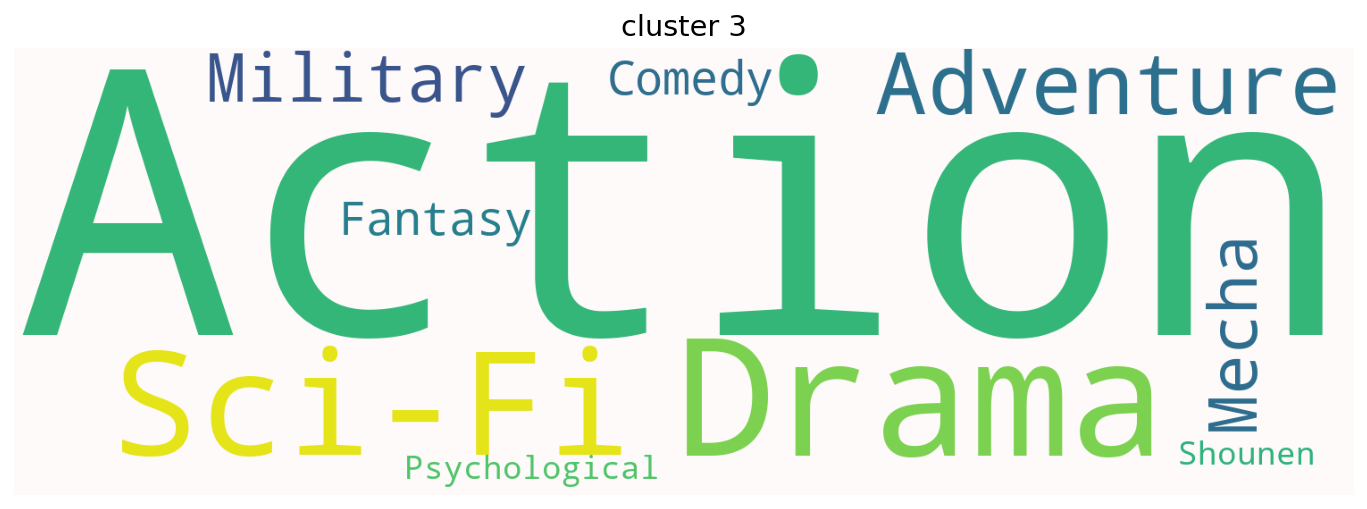

In [63]:
c3_animelist = list(c3.sort_values(ascending=False)[0:15].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['episode'],c3_data['rating'],c3_data['member'] =  createAnimeInfoList(c3_animelist)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c3_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 3","snow")

In [64]:
keyword_occurences[0:5]

[['Action', 10],
 [' Drama', 8],
 [' Sci-Fi', 6],
 [' Adventure', 6],
 [' Military', 4]]

In [65]:
print('cluster 3\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c3_data['episode'].mean(), c3_data['rating'].mean(),c3_data['member'].mean()))

cluster 3
AVG episode : 24.133333333333333
AVG movie rating : 8.0
AVG member : 561513.7333333333



---


Gracias por llegar hasta aqui. Después de este ejercicio, puedes usar esta función de clustering / agrupaciones, para recomendar animes personalizados para cada usuario. Además del contenido y las recomendaciones colaborativas, éste es un método alternativo para dar diferentes tipos de recomendacion a los usuarios.